In [1]:
# 導入必要的庫
import pandas as pd
import json
from datetime import timedelta

# 讀取 JSON 檔案
file_path = '/Users/chianlee/Desktop/disney/data/testing_data_sea.json'
file_path_names = '/Users/chianlee/Desktop/disney/data/sea_namelist.json'

with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

with open(file_path_names, 'r', encoding='utf-8') as file:
    names = json.load(file)

In [2]:
# 轉換為 DataFrame
df_data = pd.DataFrame(data)
df_names = pd.DataFrame(names)

# 刪除 'FacilityName' 欄位並移除 'StandbyTime' 為 null 的行
df_data = df_data.drop(columns=['FacilityName'])
df_data = df_data[df_data['StandbyTime'].notna()]
df_data = df_data[df_data['StandbyTime'] != False]

# 顯示處理後的5筆數據
df_data.head(5)

,StandbyTime,FacilityID,UpdateTime,datetime
0,5,234,9:00,2024-07-31 07:36
3,5,222,9:00,2024-07-31 07:36
4,5,236,9:00,2024-07-31 07:36
5,0,235,9:00,2024-07-31 07:36
6,5,220,9:00,2024-07-31 07:36


In [3]:
# 解析日期時間欄位
df_data['UpdateTime'] = pd.to_datetime(df_data['UpdateTime'], format='%H:%M')
df_data['datetime'] = pd.to_datetime(df_data['datetime'])

# 將所有 datetime 欄位加上一小時
df_data['datetime'] = df_data['datetime'] + pd.Timedelta(hours=1)

# 提取日期並應用於 UpdateTime
df_data['UpdateTime'] = df_data.apply(
    lambda row: row['UpdateTime'].replace(year=row['datetime'].year, month=row['datetime'].month, day=row['datetime'].day),
    axis=1
)

# 顯示處理後的5筆數據
df_data.head(-5)

,StandbyTime,FacilityID,UpdateTime,datetime
0,5,234,2024-07-31 09:00:00,2024-07-31 08:36:00
3,5,222,2024-07-31 09:00:00,2024-07-31 08:36:00
4,5,236,2024-07-31 09:00:00,2024-07-31 08:36:00
5,0,235,2024-07-31 09:00:00,2024-07-31 08:36:00
6,5,220,2024-07-31 09:00:00,2024-07-31 08:36:00
...,...,...,...,...
7855,20,229,2024-08-01 19:35:00,2024-08-01 20:56:00
7857,15,247,2024-08-01 15:34:00,2024-08-01 20:56:00
7858,5,233,2024-08-01 19:43:00,2024-08-01 20:56:00
7859,25,257,2024-08-01 20:44:00,2024-08-01 20:56:00


In [4]:
# 計算 UpdateTime 和 datetime 之間的時間差（以小時為單位）
df_data['time_difference'] = (df_data['datetime'] - df_data['UpdateTime'])

# 刪除時間差超過2小時的資料
df_filtered = df_data[df_data['time_difference'] <= timedelta(hours=2)]

# 刪除多餘的時間差欄位
df_filtered = df_filtered.drop(columns=['time_difference'])

# 顯示處理後的5筆數據
df_filtered.head(-5)

,StandbyTime,FacilityID,UpdateTime,datetime
0,5,234,2024-07-31 09:00:00,2024-07-31 08:36:00
3,5,222,2024-07-31 09:00:00,2024-07-31 08:36:00
4,5,236,2024-07-31 09:00:00,2024-07-31 08:36:00
5,0,235,2024-07-31 09:00:00,2024-07-31 08:36:00
6,5,220,2024-07-31 09:00:00,2024-07-31 08:36:00
...,...,...,...,...
7851,5,232,2024-08-01 19:16:00,2024-08-01 20:56:00
7852,5,231,2024-08-01 20:41:00,2024-08-01 20:56:00
7855,20,229,2024-08-01 19:35:00,2024-08-01 20:56:00
7858,5,233,2024-08-01 19:43:00,2024-08-01 20:56:00


In [5]:
# 將 StandbyTime 轉換為數值型
df_filtered['StandbyTime'] = pd.to_numeric(df_filtered['StandbyTime'], errors='coerce')

# 提取設施名稱和小時
df_filtered['Hour'] = df_filtered['datetime'].dt.hour

# 篩選 8 點到 20 點之間的數據
df_filtered = df_filtered[(df_filtered['Hour'] >= 8) & (df_filtered['Hour'] <= 20)]

# 合併數據框以添加英文設施名稱
df_filtered = df_filtered.merge(df_names[['FacilityID', 'FacilityEnglish']], on='FacilityID', how='left')

# 確保每個設施在 8 點到 20 點都有數據
all_hours = pd.DataFrame({'Hour': range(8, 21)})
all_facilities = df_filtered['FacilityEnglish'].unique()

full_df = pd.DataFrame()
for facility in all_facilities:
    facility_data = pd.merge(all_hours, df_filtered[df_filtered['FacilityEnglish'] == facility], on='Hour', how='left')
    facility_data['FacilityEnglish'] = facility
    
    # 對該設施的 StandbyTime 進行線性插值和前後填充
    facility_data['StandbyTime'] = facility_data['StandbyTime'].interpolate(method='linear').ffill().bfill()
    full_df = pd.concat([full_df, facility_data], ignore_index=True)

# 計算每個設施在 8 點到 20 點之間的平均等待時間
average_wait_times = full_df.groupby('FacilityEnglish')['StandbyTime'].mean().reset_index()

# 顯示結果
print(average_wait_times)

                                      FacilityEnglish  StandbyTime
0                        20,000 Leagues Under the Sea    16.098901
1                      Anna and Elsa's Frozen Journey    43.487179
2                                           Aquatopia    19.217172
3                                   Big City Vehicles     5.000000
4                               Blowfish Balloon Race    15.563380
5                                    Caravan Carousel     5.000000
6    DisneySea Electric Railway (American Waterfront)    10.231481
7         DisneySea Electric Railway (Port Discovery)     9.143519
8   DisneySea Transit Steamer Line (American Water...     9.444444
9   DisneySea Transit Steamer Line (Lost River Delta)     9.971264
10  DisneySea Transit Steamer Line (Mediterranean ...     9.228395
11                  Fairy Tinker Bell's Busy Buggies1    21.022727
12                     Flounder's Flying Fish Coaster    11.901408
13     Fortress Explorations "The Leonardo Challenge"     5.00

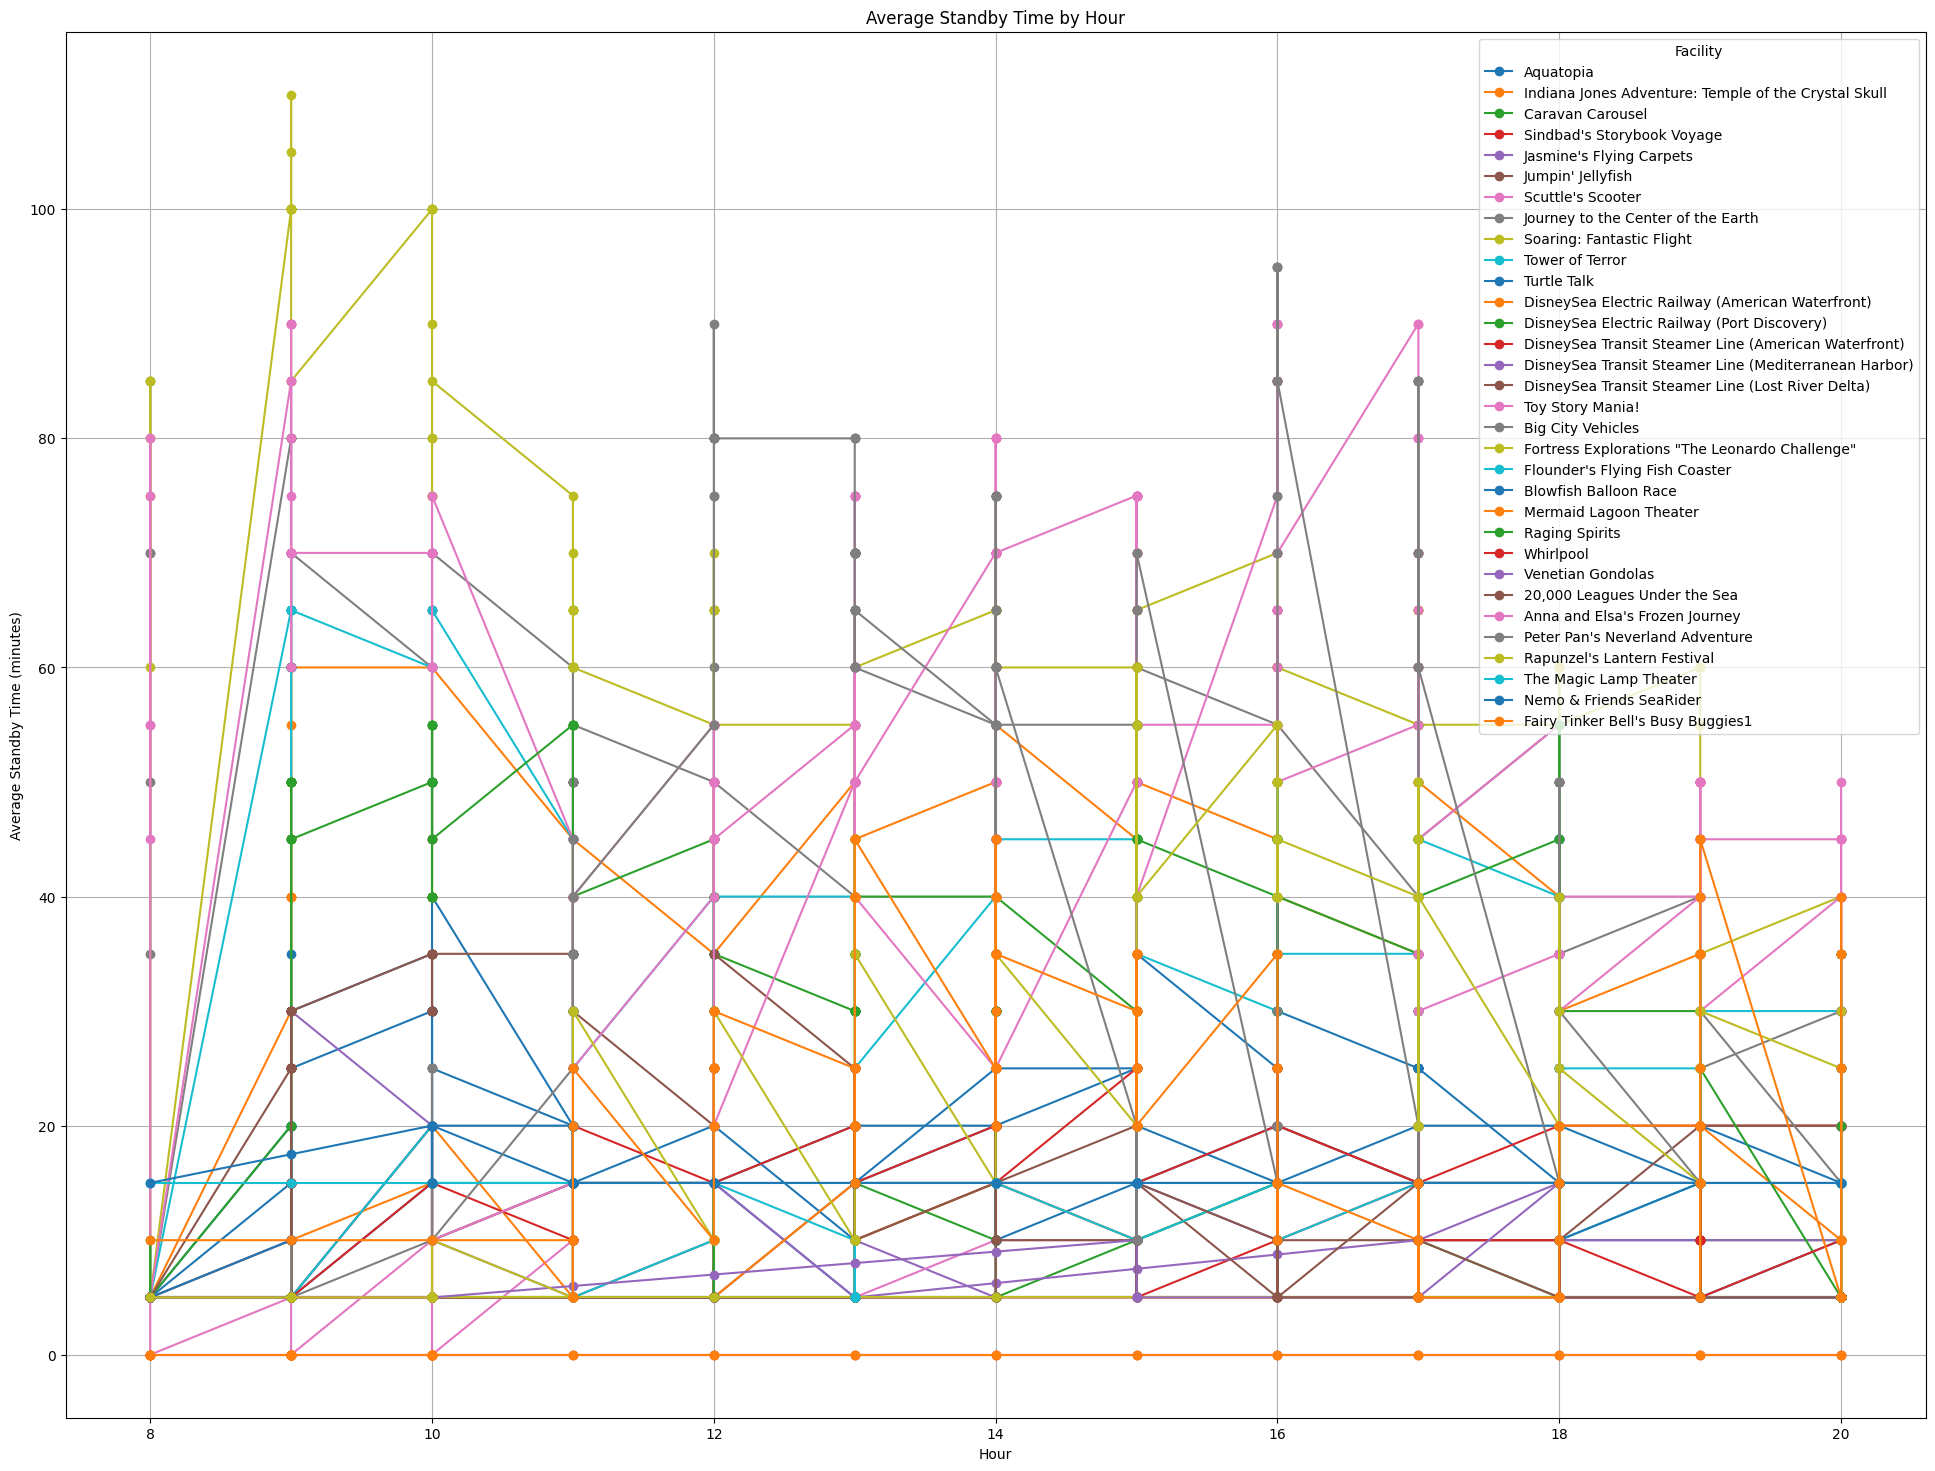

In [6]:
import matplotlib.pyplot as plt

# 設置圖表大小
plt.figure(figsize=(24, 18))

# 為每個設施畫折線
for facility in full_df['FacilityEnglish'].unique():
    facility_data = full_df[full_df['FacilityEnglish'] == facility]
    plt.plot(facility_data['Hour'], facility_data['StandbyTime'], marker='o', label=facility)

# 添加圖例和標籤
plt.legend(title='Facility')
plt.xlabel('Hour')
plt.ylabel('Average Standby Time (minutes)')
plt.title('Average Standby Time by Hour')
plt.grid(True)
plt.show()

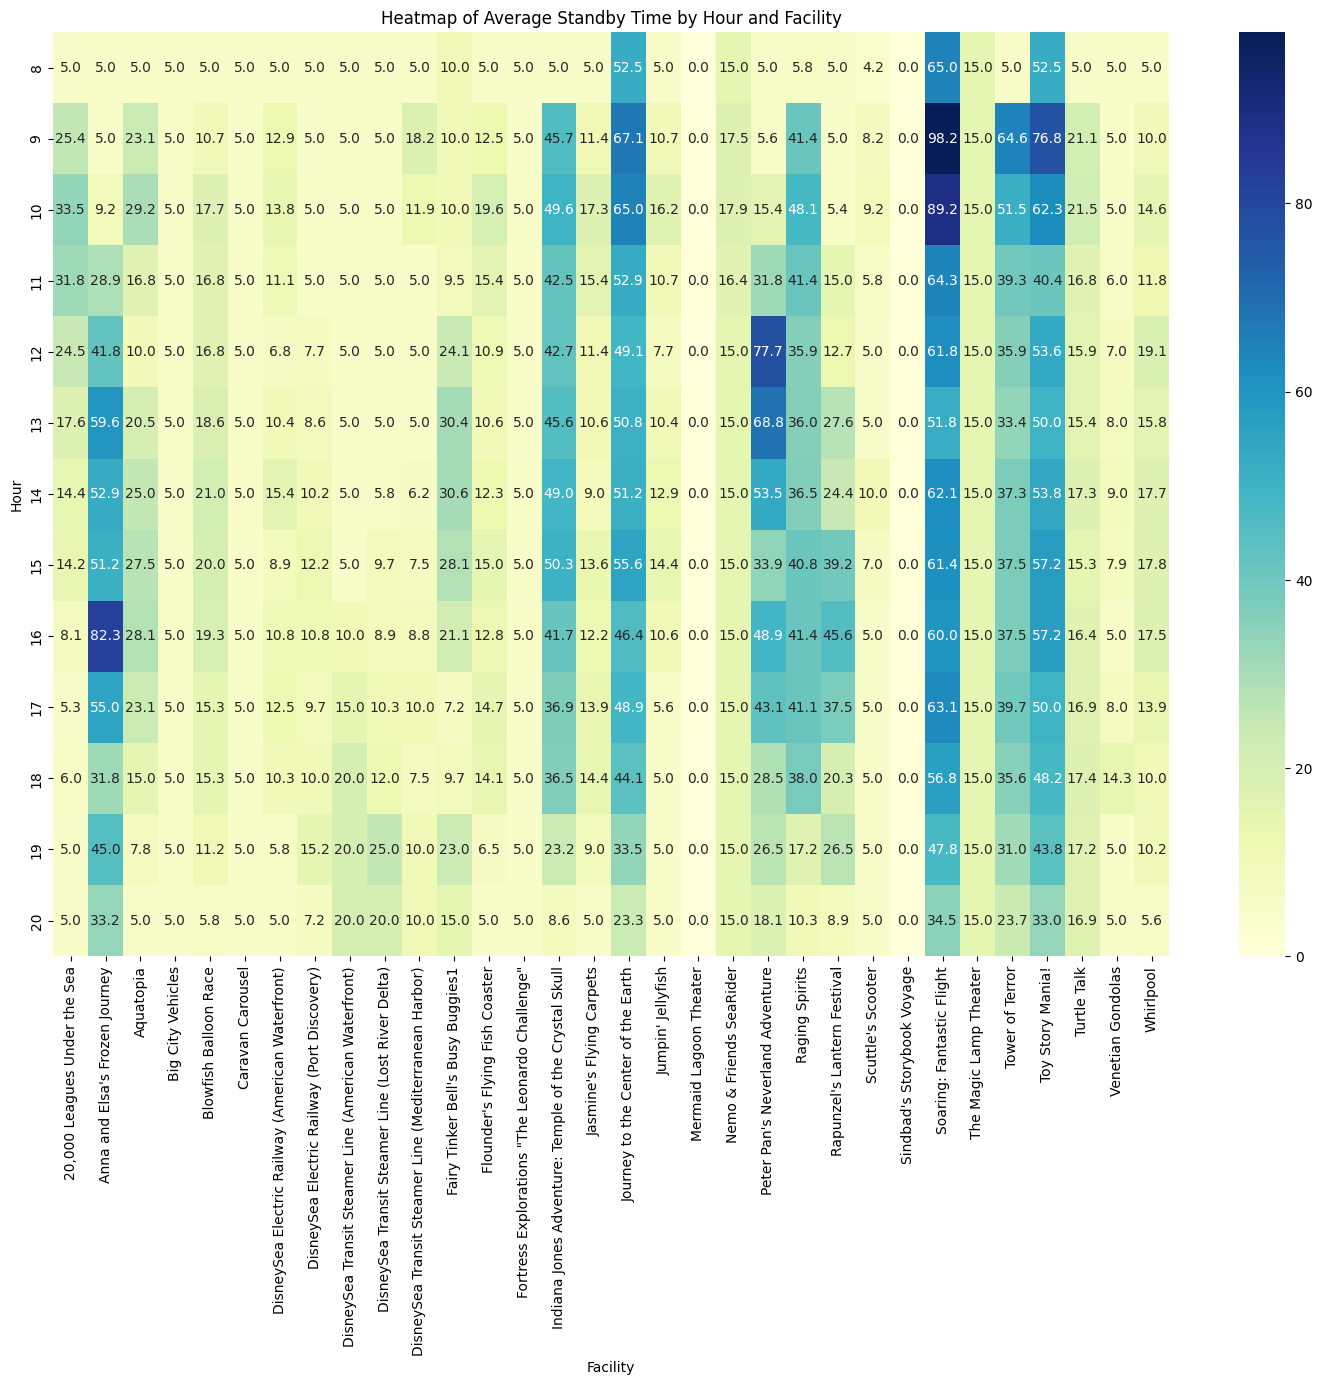

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 設置圖表大小
plt.figure(figsize=(18, 12))

# 創建透視表（pivot table）使用full_df，而非average_wait_times
pivot_df = full_df.pivot_table(index='Hour', columns='FacilityEnglish', values='StandbyTime', aggfunc='mean')

# 使用 Seaborn 繪製熱圖
sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="YlGnBu")

# 添加標題和標籤
plt.title('Heatmap of Average Standby Time by Hour and Facility')
plt.xlabel('Facility')
plt.ylabel('Hour')
plt.show()


In [8]:
full_df.describe()

,Hour,StandbyTime,UpdateTime,datetime
count,5220.000000,5220.000000,5157,5157
mean,14.390038,23.101533,2024-07-31 22:54:15.951134208,2024-07-31 23:17:45.770797056
min,8.000000,0.000000,2024-07-31 08:33:00,2024-07-31 08:36:00
25%,12.000000,10.000000,2024-07-31 12:29:00,2024-07-31 12:51:00
50%,14.000000,15.000000,2024-07-31 17:07:00,2024-07-31 17:48:00
75%,17.000000,35.000000,2024-08-01 13:48:00,2024-08-01 14:04:00
max,20.000000,110.000000,2024-08-01 20:49:00,2024-08-01 20:56:00
std,3.474261,19.590042,NaN,NaN


In [9]:
full_df.shape

(5220, 6)

In [10]:
#這邊會有null值是因為補值
full_df.isnull().sum()

Hour                0
StandbyTime         0
FacilityID         63
UpdateTime         63
datetime           63
FacilityEnglish     0
dtype: int64

In [11]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5220 entries, 0 to 5219
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Hour             5220 non-null   int64         
 1   StandbyTime      5220 non-null   float64       
 2   FacilityID       5157 non-null   object        
 3   UpdateTime       5157 non-null   datetime64[ns]
 4   datetime         5157 non-null   datetime64[ns]
 5   FacilityEnglish  5220 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 244.8+ KB
